In [5]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

In [6]:
class Strategy_comp1(bt.Strategy):
    
    params = (
        ('printlog', False),
        #('training', False),
        ('training_stake', 100),
        ('wave_period', 7),
        ('stack_len', 3),
        #('atr_initial', 10000),
        #('atr_period', 14),
        #('atr_percent', 1),
        #('atr_risk', 1),
        ('bollinger_per', 20),
        ('bollinger_dev', 2),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.buyprice = None
        self.sellprice = None

        # Add a Wave indicator
        ## Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
                    self.datas[0], period=self.params.wave_period)
        
        ## Add a Wave singal stack
        self.stack = [0] * self.params.stack_len
        
        # Add MACD indicator
        self.macdhisto = bt.indicators.MACDHisto(self.datas[0])

        # Adding an ATR indicator
        #self.tr = bt.indicators.Max((self.datahigh - self.datalow), 
        #                                                 abs(self.dataclose(-1) - self.datahigh),
        #                                                 abs(self.dataclose(-1) - self.datalow))
        #self.atr = bt.indicators.SimpleMovingAverage(self.tr, period=self.params.atr_period)
        
        # Add Bollinger Bands indicator
        self.lines.top = bt.indicators.BollingerBands(self.datas[0], 
                                                      period = self.params.bollinger_per, 
                                                      devfactor = self.params.bollinger_dev).top
        self.lines.bot = bt.indicators.BollingerBands(self.datas[0], 
                                                      period = self.params.bollinger_per, 
                                                      devfactor = self.params.bollinger_dev).bot

        # Add training analysis
        self.profit_array = np.zeros(3)
        self.position_array = np.zeros(3)
        


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.position_array += self.signal_array * self.params.training_stake
                self.profit_array -= self.signal_array * self.params.training_stake * self.buyprice
                self.log('BUY EXECUTED, Price:%.2f, Lot:%i, Cash:%i, Singal:(%i,%i,%i), Position:(%i,%i,%i)' %
                         (order.executed.price,
                          order.executed.size,
                          self.broker.get_cash(),
                          self.signal_array[0], self.signal_array[1], self.signal_array[2],
                          self.position_array[0], self.position_array[1], self.position_array[2]))

            else:  # Sell
                self.sellprice = order.executed.price
                self.position_array += self.signal_array * self.params.training_stake
                self.profit_array -= self.signal_array * self.params.training_stake * self.sellprice
                self.log('SELL EXECUTED, Price:%.2f, Lot:%i, Cash:%i, Singal:(%i,%i,%i), Position:(%i,%i,%i)' %
                        (order.executed.price,
                          -order.executed.size,
                          self.broker.get_cash(),
                          self.signal_array[0], self.signal_array[1], self.signal_array[2],
                          self.position_array[0], self.position_array[1], self.position_array[2]))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        #self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f, Profit:(%.2f, %.2f, %.2f)' %
                 (trade.pnl, trade.pnlcomm, self.profit_array[0], self.profit_array[1], self.profit_array[2]))
        
        
    def next(self):
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        #if self.order:
        #    return
        
        # Signal Detection
        self.signal_array = np.zeros(3)
        ## Bollinger Signal - array index 0
        ### Bollinger Buy Signal
        if (self.dataclose[0] > self.lines.top[0] and self.dataclose[-1] < self.lines.top[-1]) or (self.dataclose[0] > self.lines.bot[0] and self.dataclose[-1] < self.lines.bot[-1]):
            self.signal_array[0] = 1
        ### Bollinger Sell Singal
        elif  (self.dataclose[0] < self.lines.top[0] and self.dataclose[-1] > self.lines.top[-1]) or (self.dataclose[0] < self.lines.bot[0] and self.dataclose[-1] > self.lines.bot[-1]):
            if self.position_array[0] > 0:
                self.signal_array[0] = -1      

        
        ## MACD Signal - array index 1
        ### MACD Buy Signal
        if self.macdhisto.histo[0] > 0 and self.macdhisto.histo[-1] < 0:
            self.signal_array[1] = 1
                   
        ### MACD Sell Signal
        elif self.macdhisto.histo[0] < 0 and self.macdhisto.histo[-1] > 0:
                if self.position_array[1] > 0:
                    self.signal_array[1] = -1


        ## Wave Signal - array index 2
        ### Wave Buy Signal        
        for i in range(1, self.params.stack_len+1):
            self.stack[-i] = 1 if self.sma[-i+1] - self.sma[-i] > 0 else -1

        if self.stack[-1] == 1 and sum(self.stack) in [-1 * (self.params.stack_len - 2), -1 * (self.params.stack_len - 3)]:
            #### Avoid long position in Downward wave
            if self.buyprice is None:
                self.signal_array[2] = 1
            elif self.dataclose > self.buyprice:
                self.signal_array[2] = 1

        ### Wave Sell Signal
        elif self.stack[-1] == -1 and sum(self.stack) in [1 * (self.params.stack_len - 2), 1 * (self.params.stack_len - 3)]:
                if self.position_array[2] > 0:
                    self.signal_array[2] = -1
        
        
        # Buy/Sell
        if sum(self.signal_array) > 0:
            self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                        sum(self.signal_array)*self.params.training_stake, 
                        self.getposition(self.data).size))
            self.buy(size = sum(self.signal_array)*self.params.training_stake)
        elif sum(self.signal_array) < 0:
            self.log('Sell CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                        -sum(self.signal_array)*self.params.training_stake, 
                        self.getposition(self.data).size))
            self.sell(size = -sum(self.signal_array)*self.params.training_stake)
        elif sum(self.signal_array) == 0 and (not np.array_equal(self.signal_array, np.zeros(3))):
            self.log('Signal neutrallized. (%i, %i, %i)' % (self.signal_array[0], self.signal_array[1], self.signal_array[2]))


    def stop(self):
        if not np.array_equal(self.position_array, np.zeros(3)):
            self.profit_array += self.position_array * self.dataclose[0]
        self.log('Ending Position:%i, (%i, %i, %i). Ending Value:%.2f, Profit:(%.2f, %.2f, %.2f)' %
                (self.getposition(self.data).size, self.position_array[0], self.position_array[1], self.position_array[2],
                self.cerebro.broker.getvalue(),
                self.profit_array[0], self.profit_array[1], self.profit_array[2]), doprint = True)
    

# 回测

In [7]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_comp1, printlog=True) 

    s_date = datetime.datetime.now() - datetime.timedelta(days = 365)
    e_date = datetime.datetime.now()

    # Create stock Data Feed
    stock_index = '002057.SZ'
    df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
                        stock_index, s_date, e_date)
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)
    
    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(10000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

Starting Portfolio Value: 10000.00
2021-11-29: BUY CREATE, Price: 9.47, Lots: 100, Current Position: 0
2021-11-30: BUY EXECUTED, Price:9.47, Lot:100, Cash:9053, Singal:(1,0,0), Position:(100,0,0)
2021-11-30: Sell CREATE, Price: 9.15, Lots: 100, Current Position: 100
2021-12-01: SELL EXECUTED, Price:9.15, Lot:100, Cash:9968, Singal:(-1,0,0), Position:(0,0,0)
2021-12-01: OPERATION PROFIT, GROSS -32.00, NET -32.00, Profit:(-32.00, 0.00, 0.00)
2021-12-16: BUY CREATE, Price: 9.41, Lots: 100, Current Position: 0
2021-12-17: BUY EXECUTED, Price:9.41, Lot:100, Cash:9027, Singal:(0,1,0), Position:(0,100,0)
2021-12-29: Sell CREATE, Price: 9.12, Lots: 100, Current Position: 100
2021-12-30: SELL EXECUTED, Price:9.12, Lot:100, Cash:9939, Singal:(0,-1,0), Position:(0,0,0)
2021-12-30: OPERATION PROFIT, GROSS -29.00, NET -29.00, Profit:(-32.00, -29.00, 0.00)
2022-01-28: BUY CREATE, Price: 8.01, Lots: 100, Current Position: 0
2022-02-07: BUY EXECUTED, Price:8.01, Lot:100, Cash:9138, Singal:(1,0,0), Pos

<IPython.core.display.Javascript object>


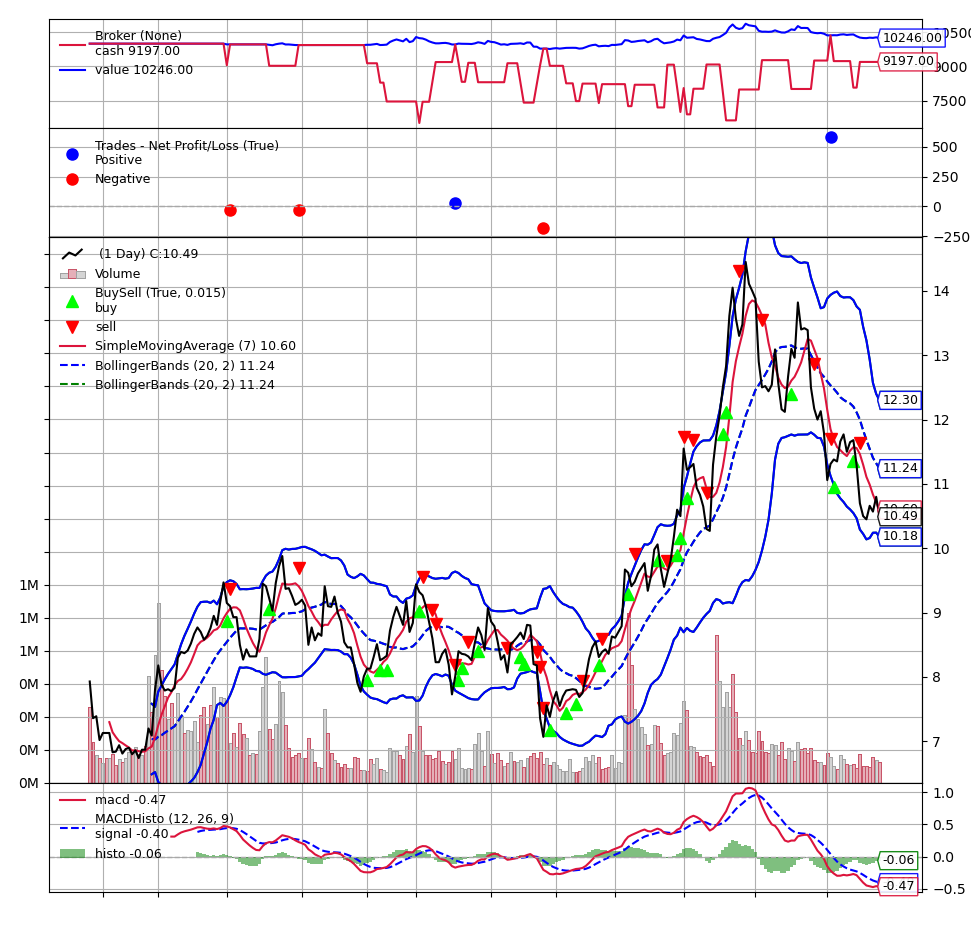

[[<Figure size 640x480 with 5 Axes>]]

In [8]:
cerebro.plot()